# Text Classification with Naive Bayes, Logistic Regression, SVM

### Overview

This notebook aims to give you a brief overview of performing text classification using Naive Bayes, Logistic Regression and Support Vector Machines. We will be using a dataset called "Economic news article tone and relevance" from [Figure-Eight](https://github.com/practical-nlp/practical-nlp/blob/master/Ch4/Data/Full-Economic-News-DFE-839861.csv) which consists of approximately 8000 news articles, which were tagged as relevant or not relevant to the US Economy. Our goal in this notebook is to explore the process of training and testing text classifiers for this problem, using this data set and two text classification algorithms: Multinomial Naive Bayes and Logistic Regression, implemented in sklearn. 

##### Dataset Link: In the a folder called Data in folder Ch4 of this repo
<br><br>
Let's import few necessary packages before we start our work

In [1]:
import numpy as np
import pandas as pd #to work with csv files

#matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

#To download the dataset
import os, subprocess

#import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words

#pre-processing of text
import string
import re

#import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

#import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

#import time function from time module to track the training duration
from time import time

/Users/vishalgupta/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


### Loading the Data

In [2]:
DATA_PATH = "Data"
URL = "https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv"
FILE_PATH = os.path.join(DATA_PATH, URL.split('/')[-1])
if not os.path.exists(FILE_PATH):
    process = subprocess.run("curl %s --output %s"%(URL, FILE_PATH), shell=True, check=True, stdout=subprocess.PIPE, universal_newlines=True)
articles_df = pd.read_csv(FILE_PATH , encoding = "ISO-8859-1")

In [3]:
print("Number of rows (instances) and columns in the dataset:",articles_df.shape)
print("Distribution of relevance (class label) :")
print(articles_df["relevance"].value_counts()/articles_df.shape[0])

Number of rows (instances) and columns in the dataset: (8000, 15)
Distribution of relevance (class label) :
no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64


- There is an imbalance in the data with **not relevant** being 82% in the dataset. 
- That is, most of the articles are not relevant to US Economy, which makes sense in a real-world scenario, as news articles discuss various topics. 
- We should keep this class imbalance mind when interpreting the classifier performance later. 

#### Encoding class labels
- 1 for Yes (relevant) & 0 for No (not relevant)
- Ignore "Not sure". 

In [4]:
articles_df = articles_df[articles_df.relevance != "not sure"]
print ("Number of rows after filtering our articles where relevance is 'not sure':",articles_df.shape)

# Convert label to a numerical variable (relevant = 1, not-relevant = 0)
articles_df['relevance'] = articles_df.relevance.map({'yes':1, 'no':0}) #

# Dropping extra columns.
articles_df = articles_df[["text","relevance"]]

Number of rows after filtering our articles where relevance is 'not sure': (7991, 15)


### Pre-processing

- Typical steps involve tokenization, lower casing, removing, stop words, punctuation markers etc, and vectorization.
- Other processes such as stemming/lemmatization can also be performed. 

Here, we are performing the following steps: 
- Removing `<br>` tags
- Removing punctuation
- Removing numbers
- Removing stopwords.

We are using sklearn's list of stopwords, but there are several other stop word lists (e.g., from NLTK). One may also use custom stopword lists depending on the task. 

In [5]:
articles_df.head()

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1


In [6]:
stopwords = stop_words.ENGLISH_STOP_WORDS
#Method to clean a document
def clean(doc): 
    #Replacing HTML line breaks with \n
    doc = doc.replace("</br>", "\n") 
    # Dropping punctuations and digits
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    #Dropping stopwords
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    return doc

## Feature-Engineering and Training (Pipeline 1)

Now we are ready for the modelling using the scikit-learn package. 

##### Steps
1. Split the data into training and test sets (75% train, 25% test)    
2. Extract features from the training data using CountVectorizer, which is a bag of words feature  implementation. We will use the pre-processing function above in conjunction with Count Vectorizer  
3. Transform the test data into the same feature vector as the training data.  
4. Train the classifier  
5. Evaluate the classifier  

#### Step 1: Train-Test Split

In [7]:
import sklearn
from sklearn.model_selection import train_test_split

# X, our input/independant variable is the column text, from which we will be extracting features
# y, our target/dependant variable is the column relevance, which we're learning to predict
X = articles_df.text 
y = articles_df.relevance
print("Input shape :",X.shape,"\t\t Output shape :",y.shape)

# split X and y into training and testing sets. By default, it splits 75% training and 25% test
#random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, train_size=0.75)
print("X_train shape :",X_train.shape,"\t y_train shape :",y_train.shape)
print("X_test shape :",X_train.shape,"\t\t y_test shape :",y_test.shape)

Input shape : (7991,) 		 Output shape : (7991,)
X_train shape : (5993,) 	 y_train shape : (5993,)
X_test shape : (5993,) 		 y_test shape : (1998,)


#### Step 2: Pre-processing and Vectorisation

In [8]:
#Instantiate a CountVectorizer to vectorise text samples based on token counts
vect = CountVectorizer(preprocessor=clean)

#Training CountVectorizer & Transforming testing data (using training data's features)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

print('X_train_dtm shape:',X_train_dtm.shape,'\tX_test_dtm:', X_test_dtm.shape)
#i.e., the dimension of our feature vector is 49753!

X_train_dtm shape: (5993, 49753) 	X_test_dtm: (1998, 49753)


#### Step 3: Train the classifier

In [9]:
#Instantiate a Multinomial Naive Bayes model
nb = MultinomialNB() 

#Train the model (while timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

# #Make predictions for X_test_dtm (Test data)
y_pred_class = nb.predict(X_test_dtm)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]

CPU times: user 8.03 ms, sys: 2.22 ms, total: 10.2 ms
Wall time: 9.07 ms


#### Step 4: Evaluate the Classifier

##### Accuracy and AUC

In [10]:
pd.Series(y_train).value_counts()

0    4915
1    1078
Name: relevance, dtype: int64

In [11]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
print("AUC: ", metrics.roc_auc_score(y_test, y_pred_prob))

Accuracy:  0.7822822822822822
AUC:  0.7251117679464362


##### Confusing matrix

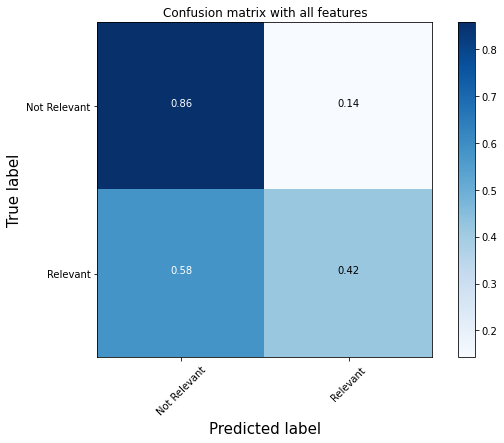

In [12]:
# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    

    
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with all features')

#### Analysing results

- At this point, we can notice that the **classifier is doing poorly with identifying relevant articles**, while it is doing **well with non-relevant ones**. 

## Pipeline 2 : MultinomialNB with 5000 features
- Our large feature vector could be creating a lot of noise in the form of very rarely occurring features that are not useful for learning. 
- Let us change the count vectorizer to take a 5000 of features as maximum, keeping in mind the number of samples available for training (5993)

In [13]:
#Vectorising the input text
vect = CountVectorizer(preprocessor=clean, max_features=5000) #Step-1
X_train_dtm = vect.fit_transform(X_train)#combined step 2 and 3
X_test_dtm = vect.transform(X_test)
print('X_train_dtm shape:',X_train_dtm.shape,'\tX_test_dtm:', X_test_dtm.shape)

#Training the Multinomial Naive Bayes model
nb = MultinomialNB() 
%time nb.fit(X_train_dtm, y_train)#train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm)#make class predictions for X_test_dtm
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]

X_train_dtm shape: (5993, 5000) 	X_test_dtm: (1998, 5000)
CPU times: user 4.94 ms, sys: 1.6 ms, total: 6.54 ms
Wall time: 6.38 ms


#### Accuracy and AUC

In [14]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
print("AUC: ", metrics.roc_auc_score(y_test, y_pred_prob))

Accuracy:  0.6881881881881882
AUC:  0.7280807695567421


#### Confusion Matrix

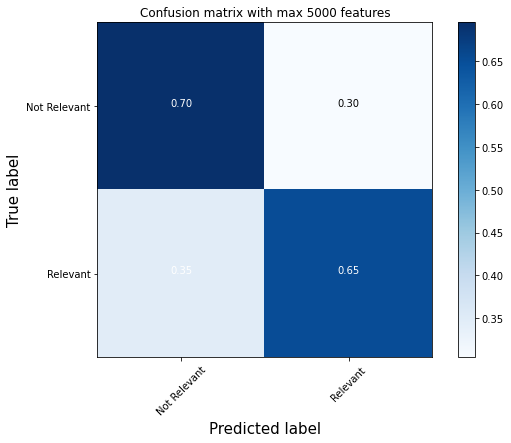

In [15]:
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with max 5000 features')

Clearly, the performance on relevance classification got better and the AUC has increased even though the overall accuracy fell by 10%. 

## Pipeline 3 : Logistic Regressor with 5000 features
Let us try another classification algorithm and see if the performance changes. For this experiment, we have considered logistic regression, with class_weight attribute as "balanced", to address the problem of class imbalance in this dataset. 

In [16]:
from sklearn.linear_model import LogisticRegression

#Instantiating and Training a logistic regression model
logreg = LogisticRegression(class_weight="balanced", solver='liblinear') 
logreg.fit(X_train_dtm, y_train)

#Making predictions on test data
y_pred_class = logreg.predict(X_test_dtm)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]

##### Accuracy and AUC

In [17]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
print("AUC: ", metrics.roc_auc_score(y_test, y_pred_prob))

Accuracy:  0.7382382382382382
AUC:  0.7280807695567421


##### Confusion Matrix

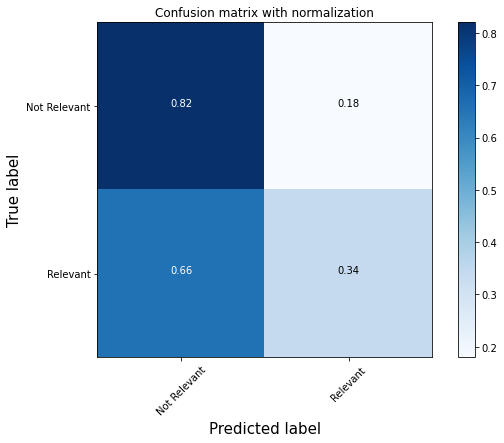

In [18]:
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')

## Pipeline 4 : Linear SVC with 1000 features
Let us wrap this notebook by trying with one more classifier, but reducing the feature vector size to 1000.

/Users/vishalgupta/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


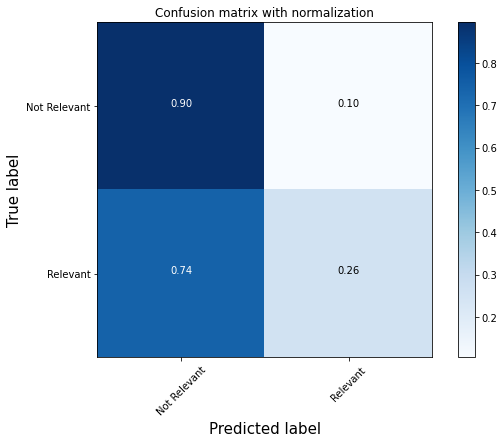

In [19]:
vect = CountVectorizer(preprocessor=clean, max_features=1000) #Step-1
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

#Instantiate and Train a Linear SVC model
classifier = LinearSVC()
classifier.fit(X_train_dtm, y_train)

#Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')

##### Accuracy

In [20]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))

Accuracy:  0.7862862862862863


##### Confusion Matrix

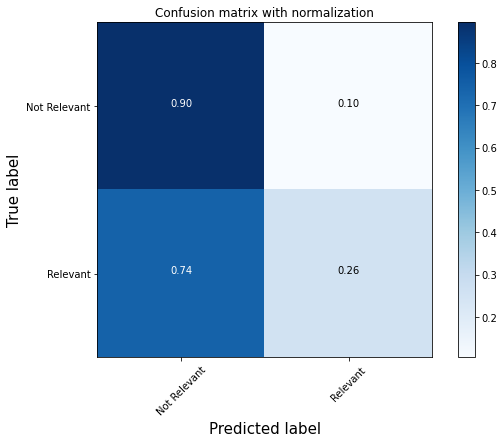

In [21]:
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')

## Conclusion
So, how do we choose whats the best? If we look at overall accuracy alone, we should be choosing the very first classifier in this notebook. However, that is also doing poorly with identifying "relevant" articles. If we choose purely based on how good it is doing with "relevant" category, we should choose the second one we built. If we choose purely based on how good it is doing with "irrelevant" category, surely, nothing beats not building any classifier and just calling everything irrelevant! So, what to choose as the best among these depends on what we are looking for in our usecase! 